# Markov Chain Monte Carlo

Markov Chain Monte Carlo (MCMC) is a method of sampling from a probability distribution. Their purpose is to approximate a probability distribution and it is supposed that they can approximate any probability distribution. This notebook will use MCMC to to approximate the distribution for the best line of fit with 3 points. For simplicity and visualization, the intercept of the line will remain 0, so perhaps it would be more appropriate to say we are modelling the best *slope* of fit. In any case, the example will work like this.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Setup

We have 3 data points defined as `pts` below. We are quite confident after plotting them that the slope of best fit lies somewhere between 0 and 2. Linear models are often evaluated based on the $R^2$ or sum of residual squares (SSR).

In [2]:
pts = np.array([[-2,-2],
                [ 1,-1],
                [3, 1]])

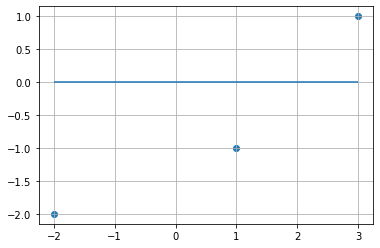

In [3]:
plt.scatter(pts[:,0],pts[:,1])
plt.hlines(0, -2, 3)
plt.grid(True)
plt.show()

Instead of y = mx + b, we just use y = mx, so that we can visualize R2 and SSR as slope changes

In [4]:
slope = np.linspace(-2,2,200)
ys = np.concatenate([np.atleast_2d(slope * pts[i,0]).T for i in range(3)], axis=1).T

In [5]:
sst = np.square(pts[:,1]).sum()

In [6]:
sst

6

Below is a line plot charting the reciprocal of SSR ($\frac{1}{SSR}$) against different slopes and we can see a peak around a slope of 0.5. Where SSR is lowest, $\frac{1}{SSR}$ is highest. The point of this plot is to demonstrate that MCMC does not have to be used strictly with probability distribution, but also with any kind of scoring function. Essentially, we will be using MCMC to sample a distribution that is proportional to the "distribution" that we see in the plot.

In [7]:
ssr = np.array([np.square(ys[:,i] - pts[:,1]).sum() for i in range(ys.shape[1])])

In [8]:
r2 = 1 - ssr/sst

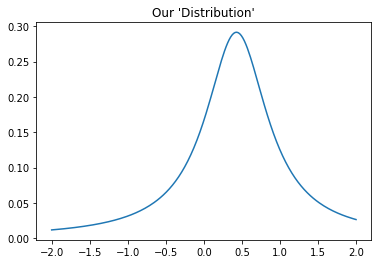

In [9]:
plt.plot(slope, 1/ssr)
plt.title("Our 'Distribution'")
# plt.vlines([-.5,-.25], ymin=0, ymax=.3)
plt.show()

## MCMC

MCMC works by chaining together steps. Each step works like this:

1. The model has some value (or vector) for the parameter(s)
2. The model obtains some score for these parameters
3. The model parameters are then changed by a random amount in a random direction (this is called sampling)
4. Three things can happen:
    1. The model can obtain a higher score based on the new parameters. In this case, the model instantly accepts these new parameters and adds a new "link" to the chain with the values of the parameters.
    2. The model can obtain a lower score based on the new parameters. A randomly generated number may ___reject___ the new (worse) parameters.
    3. The model can obtain a lower score based on the new parameters. A randomly generated number may ___accept___ to accept the new (worse) parameters.
5. Steps 4 and 5 are repeated until there are sufficient links in the Markov chain
   
At every step where the new score is less then old score, a random number is generated such that the probability of keeping the new parameters is proportional to the ratio of the lower score over the higher score. Otherwise, the new parameters are accepted immediately. This way, the Markov chain tends toward optimal parameter values and the chain "converges", not to one value, but to one distribution that can be visualized.

In [10]:
slope = 0
slope_history = np.zeros(1000)
slope_history[0] = slope

y = slope * pts[:,0]
sst = 6
ssr = np.square(y - pts[:,1]).sum()
ssr_history = np.zeros(1000)
ssr_history[0] = ssr

drift = lambda : np.random.normal(scale=.25)

accept = False

In [11]:
for i in range(1,1000):

    # Make slope wander
    slope = slope_history[i-1] + drift()
    y = slope * pts[:,0]
    ssr = np.square(y - pts[:,1]).sum()

    # if current ssr is less then the previous ssr, accept and continue
    if ssr > ssr_history[i-1]:
        p = ssr_history[i-1]/ssr # The current SSR's "power" relative to the previous one
        accept = np.random.choice([True, False], p=[p, 1-p])
        if not accept: # If we do not accept, we go to the beginning and try again
            slope_history[i] = slope_history[i-1]
            ssr_history[i] = ssr_history[i-1]
            continue

    # If we pass all the tests, record all the results and move on the next step
    slope_history[i] = slope
    ssr_history[i] = ssr

In [12]:
p, 1-p

(0.7597993976531564, 0.2402006023468436)

In [13]:
ssr

5.878467082737986

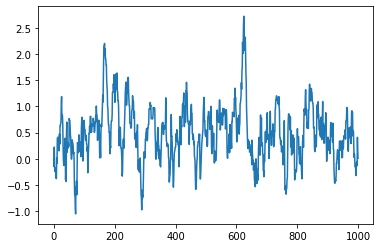

In [14]:
plt.plot(slope_history)

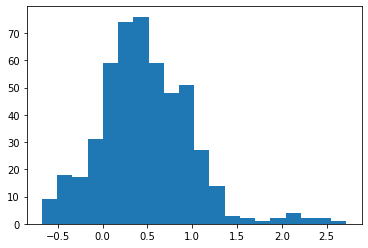

In [15]:
plt.hist(slope_history[500:], bins=20)
plt.show()

In [16]:
np.median(slope_history)

0.4531158903239566

## PyMC3

PyMC3 is an API for MCMC that makes defining a model and sampling a posterior easy and straightforward. By defining random variables and their relationships, PyMC3 is able to easily combine and transform distributions by using the log-probabilities as the scoring function. Then after providing observed data, PyMC3 generates a Markov chain which can easily be plotted and analyzed. Below is an example of our best slope-of-fit using PyMC3.

In [17]:
import pymc3 as pm

X, y = pts[:,0], pts[:,1]
with pm.Model() as linear_model:
    weight = pm.Normal("weight", mu=0, sigma=1)
    noise = pm.Gamma("noise", alpha=2, beta=1)
    y_observed = pm.Normal(
        "y_observed",
        mu=X @ weight,
        sigma=noise,
        observed=y,
    )

    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

/tmp/ipykernel_16225/3189802570.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  posterior = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, weight]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


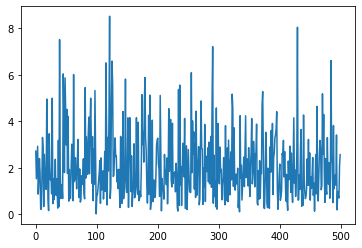

In [18]:
plt.plot(prior['noise'])
plt.show()

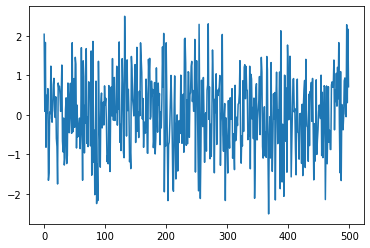

In [19]:
plt.plot(prior['weight'])
plt.show()

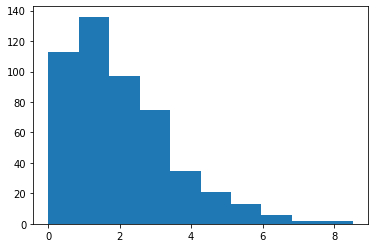

In [20]:
plt.hist(prior['noise'])
plt.show()

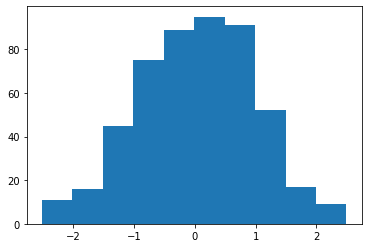

In [21]:
plt.hist(prior['weight'])
plt.show()

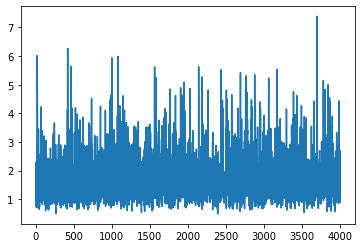

In [22]:
plt.plot(posterior['noise'])
plt.show()

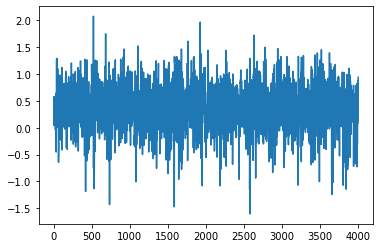

In [23]:
plt.plot(posterior['weight'])
plt.show()

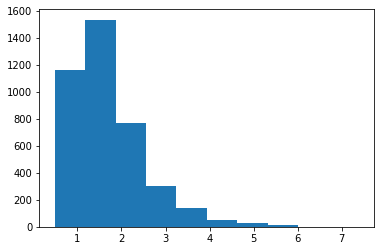

In [24]:
plt.hist(posterior['noise'])
plt.show()

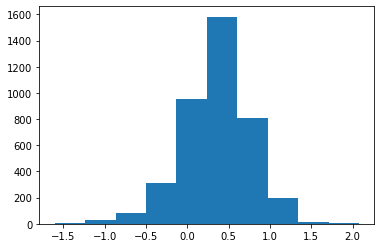

In [25]:
plt.hist(posterior['weight'])
plt.show()

In [26]:
np.median(posterior['weight'])

0.37334780701568226